In [27]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


## Preparation

In [4]:
df['card'] = (df.card == 'yes').astype(int)

In [5]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [6]:
y = df['card']
X = df.drop("card", axis=1)

In [7]:
df_full_train, df_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=1 )

## Question 1

In [8]:
features = ["reports", "dependents", "active", "share"]

results = []
for var in features:
    score = roc_auc_score(y_train, df_train[var])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[var])
    results.append(score)

output = pd.DataFrame(results, columns=["Score"], index=features)
    

In [9]:
output.sort_values(by="Score", ascending=False)

,Score
share,0.989184
reports,0.716663
active,0.604317
dependents,0.532776


## training the model

In [10]:
used_features = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
df_full_train = df_full_train[used_features]
df_train = df_train[used_features]
df_val = df_val[used_features]
df_test = df_test[used_features]

In [11]:
dv = DictVectorizer(sparse=False)
dicts = df_train.to_dict(orient="records")
X_train = dv.fit_transform(dicts)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

In [12]:
val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)
y_pred = model.predict_proba(X_val)[:,1]
score = roc_auc_score(y_val, y_pred)

In [13]:
score.round(3)

0.995

## Question 3

In [14]:
thresholds = np.arange(0, 1, 0.01)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [15]:
results = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    results.append((t, tp, fp, fn, tn))

In [17]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(results, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)



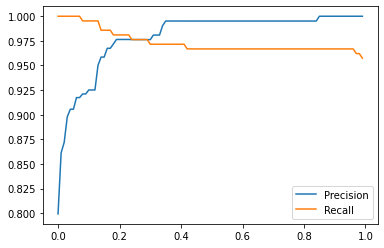

In [20]:
plt.plot(df_scores.threshold, df_scores.precision, label="Precision")
plt.plot(df_scores.threshold, df_scores.recall, label="Recall")
plt.legend()
plt.show()



## Question 4

In [21]:
df_scores["f1"] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

In [23]:
df_scores.sort_values(by="f1", ascending=False).head(20)

,threshold,tp,fp,fn,tn,precision,recall,f1
35,0.35,205,1,6,52,0.995146,0.971564,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.983213
41,0.41,205,1,6,52,0.995146,0.971564,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.983213
39,0.39,205,1,6,52,0.995146,0.971564,0.983213
40,0.40,205,1,6,52,0.995146,0.971564,0.983213
89,0.89,204,0,7,53,1.000000,0.966825,0.983133
85,0.85,204,0,7,53,1.000000,0.966825,0.983133
87,0.87,204,0,7,53,1.000000,0.966825,0.983133


## Question 5

In [24]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [25]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [28]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train.iloc[train_idx]
    y_val = y_full_train.iloc[val_idx]

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [30]:
np.std(scores).round(3)

0.003

## Question 6

In [31]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [32]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [35]:
results = []
for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train.iloc[train_idx]
        y_val = y_full_train.iloc[val_idx]

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    results.append((C, np.mean(scores).round(3), np.std(scores).round(3)))

final_result = pd.DataFrame(results, columns=['C', 'mean', 'std'])    

In [37]:
final_result.sort_values(by="mean", ascending=False)

,C,mean,std
2,1.00,0.996,0.003
3,10.00,0.996,0.003
1,0.10,0.995,0.004
0,0.01,0.992,0.006
